In [1]:
import root_pandas as rp
import pandas as pd
import ROOT
import numpy as np
import matplotlib.pyplot as plt

f = '/Users/vahsengrouplaptop/workspace/thesis_data/mc_with_reco_cm.root'
rf = ROOT.TFile(f)
rf.ls() #list tree names

Welcome to JupyROOT 6.18/04


## Adding boosting to CM and adding CM branches

(array([319715., 298186., 186382., 126900.,  85099.,  60439.,  48121.,
         42774.,  38465.,  30024.,  13826.,   2966.,   1453.,   1231.,
          1035.,    905.,    767.,    698.,    610.,    542.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
 <a list of 20 Patch objects>)

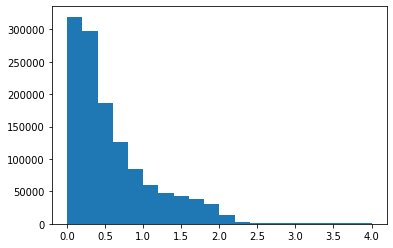

In [231]:
e = rp.read_root(f, key='e_lab') #Use only electrons, muons produce same charges and momenta
E = np.sqrt(e['p']**2+e['M']**2) #get energy of lepton tracks
e['E'] = E #add energy branch
gamma = (8+3.5)/10.58 #detector gamma given by (E_LER + E_HER)/E_upsilon(4s)
beta = np.sqrt((gamma**2-1)/gamma**2)
boost = beta*gamma
e['pz_cm']=-beta*gamma*e['E']+gamma*e['pz'] #From lorentz transformation
e['p_cm'] = np.sqrt((e['px'])**2+(e['py'])**2+(e['pz_cm'])**2) #Only z is boosted
#cm_pz = []
#to test performance of hand code vs ROOT TLorentzVector
#for px, py, pz, E in zip(e['px'].to_numpy(), e['py'].to_numpy(), e['pz'].to_numpy(), e['E'].to_numpy()):
#    v = ROOT.TLorentzVector()
#    v.SetPxPyPzE(px, py, pz, E)
#    v.Boost(0,0,-beta)
#    cm_pz.append(v.Pz())
#e['ROOT_pz_cm'] = cm_pz
plt.hist(e['p_cm'], bins = 20, range = (0,4))

#### Determining indices of 2 highest momentum events

In [237]:
e = e.loc[(e['p_cm']<2.5) & (e['p_cm']>0.25)]
e.index = [i for i in range(0,len(e))]
index = e.groupby(['__event__'])['p_cm'].nlargest(2)
indices = []
for i in range(0,len(index)):
    indices.append(index.index[i][1])
indices = np.array(indices)
indices = np.sort(indices)

#### Loading B file to compare event level SF and OF with truth

In [242]:
B = rp.read_root('/Users/vahsengrouplaptop/workspace/thesis_data/mc_with_deltaT.root', key='truthB_lab')
B = B.loc[B.index.duplicated()==False]
B.index = [i for i in range(0,len(B))]

#### Comparing SF and OF between truth B's and reconstructed lepton tracks before further cuts

In [243]:
df_red = e.iloc[indices]
df_red.index = [i for i in range(0,len(df_red))]
odd_index = [i for i in range(0,len(df_red)) if i%2 == 1]
## Code below is quick way to deterine OF and SF exploiting .diff() and odd indices
df_red['OF']=0
df_red['SF']=0
df_red['SF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]==0].index.to_numpy()]=1
df_red['SF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]==0].index.to_numpy()-1]=1
df_red['OF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]!=0].index.to_numpy()]=1
df_red['OF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]!=0].index.to_numpy()-1]=1
##
df_red = df_red.loc[df_red['__event__'].isin(B['__event__'].unique())]
B = B.loc[B['__event__'].isin(df_red['__event__'].unique())]
df_red.index = [i for i in range(0,len(df_red))]
B.index = [i for i in range(0,len(B))]
df_red['B_OF']=B['OF']
df_red['B_SF']=B['SF']
df_red[['__event__','charge','OF','SF','B_OF','B_SF']]
#df_red = df_red.loc[(df_red['pz']>-1.5) & (df_red['pz']<2.75)]
len(df_red.loc[df_red['OF']!=df_red['B_OF']])/len(df_red) #shows mistagging fraction

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

0.25418630198868597

### Looking at discriminating variables between properly tagged and mistagged events

In [ ]:
df_tag = df_red.loc[df_red['OF']==df_red['B_OF']] #properly tagged events
df_mistag = df_red.loc[df_red['OF']!=df_red['B_OF']] #mistagged events
i = 1
columns = [col for col in df_tag.columns]
fig = plt.figure(figsize=(24,36))
for col in df_tag.columns:
    try:
        plt.subplot(14,5,i)
        mean = df_tag[col].mean()
        std = df_tag[col].std()
        min = df_tag[col].mean() - 5*df_tag[col].std()
        max = df_tag[col].mean() + 5*df_tag[col].std()
        plt.hist(df_tag[col], alpha = 0.5, bins = 60, range = (min,max))
        plt.hist(df_mistag[col], alpha = 0.5, bins = 60, range = (min,max))
        plt.title(col)
        #plt.yscale("Log")
        i+=1
    except ValueError:
        pass
fig.tight_layout()
fig.show()


In [245]:
def do_cuts(low_cut,high_cut):
    e = rp.read_root(f, key='e_lab') #Use only electrons, muons produce same charges and momenta
    E = np.sqrt(e['p']**2+e['M']**2) #get energy of lepton tracks
    e['E'] = E #add energy branch
    gamma = (8+3.5)/10.58 #detector gamma given by (E_LER + E_HER)/E_upsilon(4s)
    beta = np.sqrt((gamma**2-1)/gamma**2)
    boost = beta*gamma
    e['pz_cm']=-beta*gamma*e['E']+gamma*e['pz'] #From lorentz transformation
    e['p_cm'] = np.sqrt((e['px'])**2+(e['py'])**2+(e['pz_cm'])**2) #Only z is boosted
    e = e.loc[(e['p_cm']<high_cut) & (e['p_cm']>low_cut)]
    e.index = [i for i in range(0,len(e))]
    index = e.groupby(['__event__'])['p_cm'].nlargest(2)
    indices = []
    for i in range(0,len(index)):
        indices.append(index.index[i][1])
    indices = np.array(indices)
    indices = np.sort(indices)
    B = rp.read_root('/Users/vahsengrouplaptop/workspace/thesis_data/mc_with_deltaT.root', key='truthB_lab')
    B = B.loc[B.index.duplicated()==False]
    B.index = [i for i in range(0,len(B))]
    df_red = e.iloc[indices]
    df_red.index = [i for i in range(0,len(df_red))]
    odd_index = [i for i in range(0,len(df_red)) if i%2 == 1]
    ## Code below is quick way to deterine OF and SF exploiting .diff() and odd indices
    df_red['OF']=0
    df_red['SF']=0
    df_red['SF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]==0].index.to_numpy()]=1
    df_red['SF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]==0].index.to_numpy()-1]=1
    df_red['OF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]!=0].index.to_numpy()]=1
    df_red['OF'][df_red.loc[odd_index].loc[df_red['charge'].diff()[odd_index]!=0].index.to_numpy()-1]=1
    ##
    df_red = df_red.loc[df_red['__event__'].isin(B['__event__'].unique())]
    B = B.loc[B['__event__'].isin(df_red['__event__'].unique())]
    df_red.index = [i for i in range(0,len(df_red))]
    B.index = [i for i in range(0,len(B))]
    df_red['B_OF']=B['OF']
    df_red['B_SF']=B['SF']
    df_red[['__event__','charge','OF','SF','B_OF','B_SF']]
    #df_red = df_red.loc[(df_red['pz']>-1.5) & (df_red['pz']<2.75)]
    mistag_frac = len(df_red.loc[df_red['OF']!=df_red['B_OF']])/len(df_red) #shows mistagging fraction
    return mistag_frac
mistag = do_cuts(0.25, 2.5)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/

In [ ]:
low_cuts = np.linspace(0,0.5,11)
high_cuts = np.linspace(1,3,21)
lc_list = []
hc_list = []
mistag_list = []
for lc in low_cuts:
    for hc in high_cuts:
        lc_list.append(lc)
        hc_list.append(hc)
        mistag = do_cuts(lc,hc)
        mistag_list.append(mistag)
df = pd.DataFrame()
df['lc'] = lc_list
df['hc'] = hc_list
df['mistag_fraction'] = mistag_list

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/

In [ ]:
df.loc[df['mistag_fraction']==df['mistag_fraction'].min()]